# DCGAN生成漫画头像

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/resource/_static/logo_notebook.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.3.0rc2/tutorials/application/zh_cn/generative/mindspore_dcgan.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/resource/_static/logo_download_code.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.3.0rc2/tutorials/application/zh_cn/generative/mindspore_dcgan.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/resource/_static/logo_source.svg)](https://gitee.com/mindspore/docs/blob/r2.3.0rc2/tutorials/application/source_zh_cn/generative/dcgan.ipynb)

在下面的教程中，我们将通过示例代码说明DCGAN网络如何设置网络、优化器、如何计算损失函数以及如何初始化模型权重。在本教程中，使用的[动漫头像数据集](https://download.mindspore.cn/dataset/Faces/faces.zip)共有70,171张动漫头像图片，图片大小均为96\*96。

In [1]:
%%capture captured_output
# 实验环境已经预装了mindspore==2.3.0rc1，如需更换mindspore版本，可更改下面mindspore的版本号
!pip uninstall mindspore -y
!pip install -i https://pypi.mirrors.ustc.edu.cn/simple mindspore==2.3.0rc1

In [ ]:
# 查看当前 mindspore 版本
!pip show mindspore

In [2]:
from download import download

url = "https://download.mindspore.cn/dataset/Faces/faces.zip"

path = download(url, "./faces", kind="zip", replace=True)


file_sizes: 100%|████████████████████████████| 288M/288M [00:10<00:00, 28.4MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./faces


## GAN基础原理

这部分原理介绍参考[GAN图像生成](https://www.mindspore.cn/tutorials/application/zh-CN/r2.3.0rc2/generative/gan.html#模型简介)。

## DCGAN原理

DCGAN（深度卷积对抗生成网络，Deep Convolutional Generative Adversarial Networks）是GAN的直接扩展。不同之处在于，DCGAN会分别在判别器和生成器中使用卷积和转置卷积层。

它最早由Radford等人在论文[Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf)中进行描述。判别器由分层的卷积层、BatchNorm层和LeakyReLU激活层组成。输入是3x64x64的图像，输出是该图像为真图像的概率。生成器则是由转置卷积层、BatchNorm层和ReLU激活层组成。输入是标准正态分布中提取出的隐向量$z$，输出是3x64x64的RGB图像。

本教程将使用动漫头像数据集来训练一个生成式对抗网络，接着使用该网络生成动漫头像图片。

## 数据准备与处理

首先我们将数据集下载到指定目录下并解压。示例代码如下：

下载后的数据集目录结构如下：

```text
./faces/faces
├── 0.jpg
├── 1.jpg
├── 2.jpg
├── 3.jpg
├── 4.jpg
    ...
├── 70169.jpg
└── 70170.jpg
```

### 数据处理

首先为执行过程定义一些输入（为缩短体验运行时间，此处降低了num_epochs以及数据集num_samples，若需得出较高精度结果请调整以上参数）

In [3]:
batch_size = 64          # 批量大小
image_size = 64           # 训练图像空间大小
nc = 3                    # 图像彩色通道数
nz = 100                  # 隐向量的长度
ngf = 64                  # 特征图在生成器中的大小
ndf = 64                  # 特征图在判别器中的大小
num_epochs = 2           # 训练周期数
lr = 0.0002               # 学习率
beta1 = 0.5               # Adam优化器的beta1超参数

定义`create_dataset_imagenet`函数对数据进行处理和增强操作。

In [ ]:
import numpy as np
import mindspore.dataset as ds
import mindspore.dataset.vision as vision

def create_dataset_imagenet(dataset_path):
    """数据加载"""
    dataset = ds.ImageFolderDataset(dataset_path,
                                    num_parallel_workers=4,
                                    shuffle=True,
                                    decode=True,
                                   num_samples=20000)

    # 数据增强操作
    transforms = [
        vision.Resize(image_size),
        vision.CenterCrop(image_size),
        vision.HWC2CHW(),
        lambda x: ((x / 255).astype("float32"))
    ]

    # 数据映射操作
    dataset = dataset.project('image')
    dataset = dataset.map(transforms, 'image')

    # 批量操作
    dataset = dataset.batch(batch_size)
    return dataset

dataset = create_dataset_imagenet('./faces')

通过`create_dict_iterator`函数将数据转换成字典迭代器，然后使用`matplotlib`模块可视化部分训练数据。

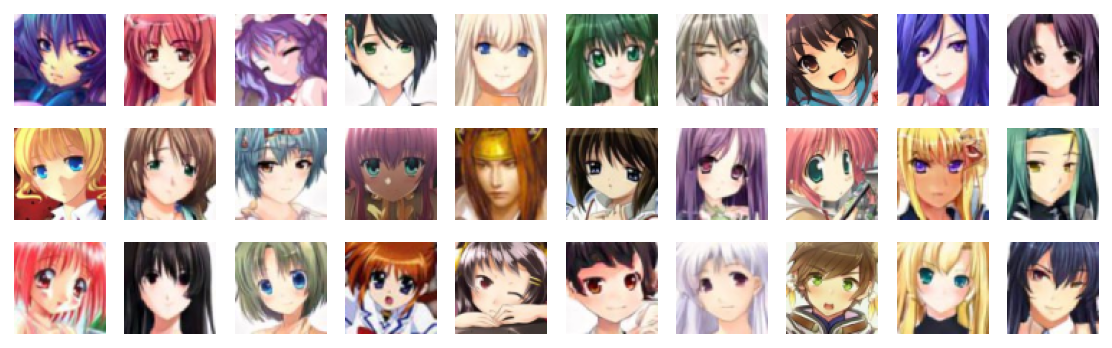

In [5]:
import matplotlib.pyplot as plt

def plot_data(data):
    # 可视化部分训练数据
    plt.figure(figsize=(10, 3), dpi=140)
    for i, image in enumerate(data[0][:30], 1):
        plt.subplot(3, 10, i)
        plt.axis("off")
        plt.imshow(image.transpose(1, 2, 0))
    plt.show()

sample_data = next(dataset.create_tuple_iterator(output_numpy=True))
plot_data(sample_data)

## 构造网络

当处理完数据后，就可以来进行网络的搭建了。按照DCGAN论文中的描述，所有模型权重均应从`mean`为0，`sigma`为0.02的正态分布中随机初始化。

### 生成器

生成器`G`的功能是将隐向量`z`映射到数据空间。由于数据是图像，这一过程也会创建与真实图像大小相同的 RGB 图像。在实践场景中，该功能是通过一系列`Conv2dTranspose`转置卷积层来完成的，每个层都与`BatchNorm2d`层和`ReLu`激活层配对，输出数据会经过`tanh`函数，使其返回`[-1,1]`的数据范围内。

DCGAN论文生成图像如下所示：

![dcgangenerator](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/tutorials/application/source_zh_cn/cv/images/dcgan.png)

> 图片来源：[Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf).

我们通过输入部分中设置的`nz`、`ngf`和`nc`来影响代码中的生成器结构。`nz`是隐向量`z`的长度，`ngf`与通过生成器传播的特征图的大小有关，`nc`是输出图像中的通道数。

以下是生成器的代码实现：

In [6]:
import mindspore as ms
from mindspore import nn, ops
from mindspore.common.initializer import Normal

weight_init = Normal(mean=0, sigma=0.02)
gamma_init = Normal(mean=1, sigma=0.02)

class Generator(nn.Cell):
    """DCGAN网络生成器"""

    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.SequentialCell(
            nn.Conv2dTranspose(nz, ngf * 8, 4, 1, 'valid', weight_init=weight_init),
            nn.BatchNorm2d(ngf * 8, gamma_init=gamma_init),
            nn.ReLU(),
            nn.Conv2dTranspose(ngf * 8, ngf * 4, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf * 4, gamma_init=gamma_init),
            nn.ReLU(),
            nn.Conv2dTranspose(ngf * 4, ngf * 2, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf * 2, gamma_init=gamma_init),
            nn.ReLU(),
            nn.Conv2dTranspose(ngf * 2, ngf, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf, gamma_init=gamma_init),
            nn.ReLU(),
            nn.Conv2dTranspose(ngf, nc, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.Tanh()
            )

    def construct(self, x):
        return self.generator(x)

generator = Generator()

### 判别器

如前所述，判别器`D`是一个二分类网络模型，输出判定该图像为真实图的概率。通过一系列的`Conv2d`、`BatchNorm2d`和`LeakyReLU`层对其进行处理，最后通过`Sigmoid`激活函数得到最终概率。

DCGAN论文提到，使用卷积而不是通过池化来进行下采样是一个好方法，因为它可以让网络学习自己的池化特征。

判别器的代码实现如下：

In [7]:
class Discriminator(nn.Cell):
    """DCGAN网络判别器"""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.SequentialCell(
            nn.Conv2d(nc, ndf, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf * 2, gamma_init=gamma_init),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf * 4, gamma_init=gamma_init),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 'pad', 1, weight_init=weight_init),
            nn.BatchNorm2d(ngf * 8, gamma_init=gamma_init),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 8, 1, 4, 1, 'valid', weight_init=weight_init),
            )
        self.adv_layer = nn.Sigmoid()

    def construct(self, x):
        out = self.discriminator(x)
        out = out.reshape(out.shape[0], -1)
        return self.adv_layer(out)

discriminator = Discriminator()

## 模型训练

### 损失函数

当定义了`D`和`G`后，接下来将使用MindSpore中定义的二进制交叉熵损失函数[BCELoss](https://www.mindspore.cn/docs/zh-CN/r2.3.0rc2/api_python/nn/mindspore.nn.BCELoss.html)。

In [8]:
# 定义损失函数
adversarial_loss = nn.BCELoss(reduction='mean')

### 优化器

这里设置了两个单独的优化器，一个用于`D`，另一个用于`G`。这两个都是`lr = 0.0002`和`beta1 = 0.5`的Adam优化器。

In [9]:
# 为生成器和判别器设置优化器
optimizer_D = nn.Adam(discriminator.trainable_params(), learning_rate=lr, beta1=beta1)
optimizer_G = nn.Adam(generator.trainable_params(), learning_rate=lr, beta1=beta1)
optimizer_G.update_parameters_name('optim_g.')
optimizer_D.update_parameters_name('optim_d.')

### 训练模型

训练分为两个主要部分：训练判别器和训练生成器。

- 训练判别器

    训练判别器的目的是最大程度地提高判别图像真伪的概率。按照Goodfellow的方法，是希望通过提高其随机梯度来更新判别器，所以我们要最大化$log D(x) + log(1 - D(G(z))$的值。

- 训练生成器

    如DCGAN论文所述，我们希望通过最小化$log(1 - D(G(z)))$来训练生成器，以产生更好的虚假图像。

在这两个部分中，分别获取训练过程中的损失，并在每个周期结束时进行统计，将`fixed_noise`批量推送到生成器中，以直观地跟踪`G`的训练进度。

下面实现模型训练正向逻辑：

In [10]:
def generator_forward(real_imgs, valid):
    # 将噪声采样为发生器的输入
    z = ops.standard_normal((real_imgs.shape[0], nz, 1, 1))

    # 生成一批图像
    gen_imgs = generator(z)

    # 损失衡量发生器绕过判别器的能力
    g_loss = adversarial_loss(discriminator(gen_imgs), valid)

    return g_loss, gen_imgs

def discriminator_forward(real_imgs, gen_imgs, valid, fake):
    # 衡量鉴别器从生成的样本中对真实样本进行分类的能力
    real_loss = adversarial_loss(discriminator(real_imgs), valid)
    fake_loss = adversarial_loss(discriminator(gen_imgs), fake)
    d_loss = (real_loss + fake_loss) / 2
    return d_loss

grad_generator_fn = ms.value_and_grad(generator_forward, None,
                                      optimizer_G.parameters,
                                      has_aux=True)
grad_discriminator_fn = ms.value_and_grad(discriminator_forward, None,
                                          optimizer_D.parameters)

@ms.jit
def train_step(imgs):
    valid = ops.ones((imgs.shape[0], 1), mindspore.float32)
    fake = ops.zeros((imgs.shape[0], 1), mindspore.float32)

    (g_loss, gen_imgs), g_grads = grad_generator_fn(imgs, valid)
    optimizer_G(g_grads)
    d_loss, d_grads = grad_discriminator_fn(imgs, gen_imgs, valid, fake)
    optimizer_D(d_grads)

    return g_loss, d_loss, gen_imgs

循环训练网络，每经过50次迭代，就收集生成器和判别器的损失，以便于后面绘制训练过程中损失函数的图像。

In [ ]:
import mindspore

G_losses = []
D_losses = []
image_list = []

total = dataset.get_dataset_size()
for epoch in range(num_epochs):
    generator.set_train()
    discriminator.set_train()
    # 为每轮训练读入数据
    for i, (imgs, ) in enumerate(dataset.create_tuple_iterator()):
        g_loss, d_loss, gen_imgs = train_step(imgs)
        if i % 100 == 0 or i == total - 1:
            # 输出训练记录
            print('[%2d/%d][%3d/%d]   Loss_D:%7.4f  Loss_G:%7.4f' % (
                epoch + 1, num_epochs, i + 1, total, d_loss.asnumpy(), g_loss.asnumpy()))
        D_losses.append(d_loss.asnumpy())
        G_losses.append(g_loss.asnumpy())

    # 每个epoch结束后，使用生成器生成一组图片
    generator.set_train(False)
    fixed_noise = ops.standard_normal((batch_size, nz, 1, 1))
    img = generator(fixed_noise)
    image_list.append(img.transpose(0, 2, 3, 1).asnumpy())

    # 保存网络模型参数为ckpt文件
    mindspore.save_checkpoint(generator, "./generator.ckpt")
    mindspore.save_checkpoint(discriminator, "./discriminator.ckpt")

## 结果展示

运行下面代码，描绘`D`和`G`损失与训练迭代的关系图：

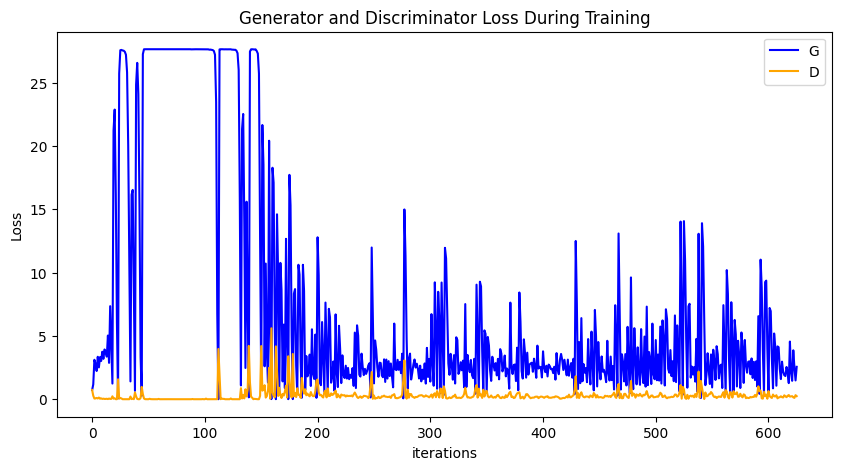

In [12]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G", color='blue')
plt.plot(D_losses, label="D", color='orange')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

可视化训练过程中通过隐向量`fixed_noise`生成的图像。

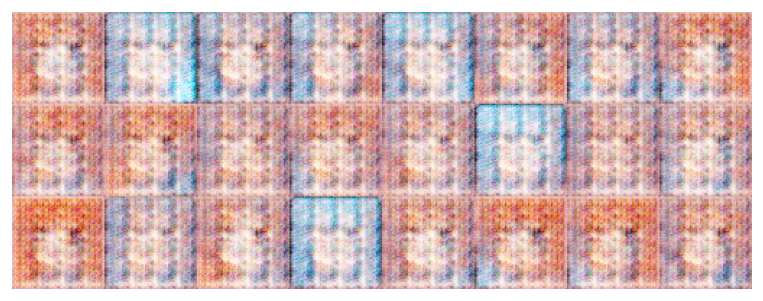

In [13]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def showGif(image_list):
    show_list = []
    fig = plt.figure(figsize=(8, 3), dpi=120)
    for epoch in range(len(image_list)):
        images = []
        for i in range(3):
            row = np.concatenate((image_list[epoch][i * 8:(i + 1) * 8]), axis=1)
            images.append(row)
        img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
        plt.axis("off")
        show_list.append([plt.imshow(img)])

    ani = animation.ArtistAnimation(fig, show_list, interval=1000, repeat_delay=1000, blit=True)
    ani.save('./dcgan.gif', writer='pillow', fps=1)

showGif(image_list)

![dcgan](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.3.0rc2/tutorials/application/source_zh_cn/cv/images/dcgan.gif)

从上面的图像可以看出，随着训练次数的增多，图像质量也越来越好。如果增大训练周期数，当`num_epochs`达到50以上时，生成的动漫头像图片与数据集中的较为相似，下面我们通过加载生成器网络模型参数文件来生成图像，代码如下：

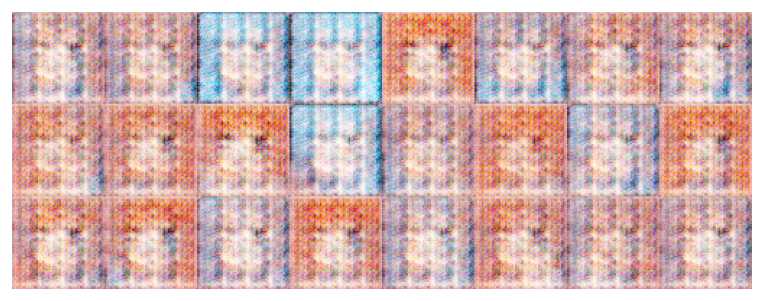

In [14]:
# 从文件中获取模型参数并加载到网络中
mindspore.load_checkpoint("./generator.ckpt", generator)

fixed_noise = ops.standard_normal((batch_size, nz, 1, 1))
img64 = generator(fixed_noise).transpose(0, 2, 3, 1).asnumpy()

fig = plt.figure(figsize=(8, 3), dpi=120)
images = []
for i in range(3):
    images.append(np.concatenate((img64[i * 8:(i + 1) * 8]), axis=1))
img = np.clip(np.concatenate((images[:]), axis=0), 0, 1)
plt.axis("off")
plt.imshow(img)
plt.show()